# Notes:
    1.How to use sample weight?
    2.Use times other than target?
    

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import sys
from src import functions as func
from src import feagen as feag
import datetime
import numpy as np
from datetime import datetime,timedelta
from keras.models import Sequential
from keras.layers import Input, Dense,LSTM,Activation,RepeatVector
from keras.layers.core import Flatten,Dropout
from keras.layers.wrappers import TimeDistributed
from sklearn import preprocessing
import keras
%matplotlib inline

task = 'am'
target = 'B-1'

if task == 'am':
    window_start = datetime.strptime('2016-10-18 08:00:00', "%Y-%m-%d %H:%M:%S")
elif task == 'pm':
    window_start = datetime.strptime('2016-10-18 17:00:00', "%Y-%m-%d %H:%M:%S")
else:
    sys.exit("Usage : Only am or pm for <task>")
    
windows = []
for d in range(7):
    for t in range(6):
        windows.append('\"['+str(window_start +timedelta(minutes=20*t))+','+ str(window_start +timedelta(minutes=20*(t+1)))+')\"')
    window_start  += timedelta(days=1)

def create_dataset(dataset,lookback = 1):
    dataX,dataY = [],[]
    for day in dataset:
        a = day[:6,0]
        b = day[6:,0]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

def create_testset(dataset,lookback=6):
    dataX = []
    for day in dataset:
        a = day[:6,0]
        dataX.append(a)
    return np.array(dataX)

    
    

def my_mape(label,pred):
    c = 0.0
    mae = 0.0
    for (l,p) in zip(label.flatten(),pred.flatten()):
        if l != 0:
            mae += abs(l-p)/l
            c += 1
    return mae/c,c

# Load data

In [66]:

win_6 = (6-6)*3
win_8 = (8-6)*3
win_10 = (10-6)*3
win_15 = (15-6)*3
win_17 = (17-6)*3
win_19 = (19-6)*3

if task == 'am':
    x_range = range(win_6,win_8)
    y_range = range(win_8,win_10)
    xy_range = range(win_6,win_10)
else:
    x_range = range(win_15,win_17)
    y_range = range(win_17,win_19)
    xy_range = range(win_15,win_19)

#Read training data
path = '../dataSets/training/'
file_suffix = '.csv'
in_file = 'trajectories(table 5)_training'
travel_times = func.read_file_to_travel_times(path, in_file, file_suffix)


#Read testing data
path = '../dataSets/testing_phase1/'
file_suffix = '.csv'
in_file = 'trajectories(table 5)_test1'
testing_times = func.read_file_to_travel_times(path, in_file, file_suffix)

#merge them into one dict
routes =  travel_times.keys()
for r in routes:
    travel_times[r].update(testing_times[r])

total_weeks = 6 # ?(train) + 1(valid) + 1(test), take off 10/1~7
training_weeks = total_weeks-2
testing_weeks = total_weeks-1
num_instance = total_weeks*7 # 13 weeks
num_window = 13*3 # 6 ~ 19
routes = travel_times.keys()
print routes
window_size = timedelta(minutes=20)
window_start = datetime.strptime('2016-09-13 06:00:00', "%Y-%m-%d %H:%M:%S")
window_end = datetime.strptime('2016-09-13 19:00:00', "%Y-%m-%d %H:%M:%S")


cube_2d = np.zeros((num_instance*num_window))

d=0
while d < num_instance:
    window_scanner = window_start
    for t in range(num_window):
        if str(window_scanner.date())>='2016-10-11' and str(window_scanner.date())<='2016-10-17' and str(window_scanner.time())>='08:00:00' and str(window_scanner.time())<'10:00:00' :
            print str(window_scanner),
            try:
                print travel_times[target][window_scanner]
            except:
                print ' None'
        try:
            cube_2d[d*39+t] = np.mean(travel_times[target][window_scanner])
        except:
            cube_2d[d*39+t] = 0
        window_scanner += window_size
    window_start += timedelta(days=1)
    d += 1


['B-3', 'B-1', 'A-3', 'A-2', 'C-3', 'C-1']
2016-10-11 08:00:00 [71.35, 101.77]
2016-10-11 08:20:00 [108.03999999999999, 146.16]
2016-10-11 08:40:00 [87.46000000000001, 87.71000000000001]
2016-10-11 09:00:00 [173.41, 93.14]
2016-10-11 09:20:00 [141.82, 111.16, 115.4, 112.78]
2016-10-11 09:40:00 [71.0, 74.63, 85.6, 94.94, 143.52]
2016-10-12 08:00:00 [116.97, 117.68]
2016-10-12 08:20:00 [154.39, 62.46, 95.46000000000001, 437.73, 170.52]
2016-10-12 08:40:00 [129.35, 82.95, 117.67, 94.56]
2016-10-12 09:00:00 [101.15]
2016-10-12 09:20:00 [95.93, 131.03, 99.03999999999999, 203.72]
2016-10-12 09:40:00  None
2016-10-13 08:00:00 [126.75, 107.9]
2016-10-13 08:20:00 [153.76, 85.26, 115.35, 93.38, 97.0, 161.85, 129.41]
2016-10-13 08:40:00 [110.98]
2016-10-13 09:00:00  None
2016-10-13 09:20:00 [109.39]
2016-10-13 09:40:00 [96.7, 113.75, 141.19, 246.51999999999998, 143.7, 136.55]
2016-10-14 08:00:00 [109.49, 146.57, 88.13, 143.35]
2016-10-14 08:20:00 [108.55, 92.22, 129.77, 91.69, 166.17000000000002,

# Feature Engineering

In [67]:
# Missing value inputation....
### to be done
# Normalize
cube_2d = cube_2d.reshape(-1, 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
normed = scaler.fit_transform(cube_2d)
#normed = preprocessing.normalize(cube_2d,axis=0)

cube_3d = np.zeros((num_instance,num_window,1))
for d in range(num_instance):
    for t in range(num_window):
        cube_3d[d][t][0] = normed[d*39+t]

train = cube_3d[:training_weeks*7,xy_range,:]
valid = cube_3d[training_weeks*7:testing_weeks*7,xy_range,:]

test = cube_3d[testing_weeks*7:,x_range,:]


look_back = 6

trX, trY = create_dataset(train, look_back)
valX,valY = create_dataset(valid,look_back)
ttX = create_testset(test,look_back)


trX = np.reshape(trX, (trX.shape[0], 1,trX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
trY = np.reshape(trY, (trY.shape[0], 1,trY.shape[1]))
ttX = np.reshape(ttX, (ttX.shape[0], 1,ttX.shape[1]))



print 'Train data:',trX.shape,trY.shape
print 'Valid data:',valX.shape,valY.shape
print 'Test data:',ttX.shape
print 'Valid non-zero',np.count_nonzero(valY.flatten())
print 'Test non-zero:',np.count_nonzero(test)



Train data: (28, 1, 6) (28, 1, 6)
Valid data: (7, 1, 6) (7, 6)
Test data: (7, 1, 6)
Valid non-zero 39
Test non-zero: 35


In [68]:

def record(model,scaler,mape,count,step,task,target,test,LSTM_out,training_weeks,windows):
    #record mape
    with open('./rnn_record/'+str(training_weeks)+'w_'+target+task+'.txt','w') as record:
        record.write('Mape :'+str(mape))
        record.write(' Count :'+str(count))
        record.write(' Epoch:'+str(step))
        record.write(' LSTM out :'+str(LSTM_out)+'\n')
    #make prediction file
    with open('./rnn_record/'+str(training_weeks)+'w_'+target+task+'.csv','w') as record:
        record.write('\"intersection_id\",\"tollgate_id\",\"time_window\",\"avg_travel_time\"\n')
        flag = 0
        for day in range(7):
            ttX = np.array(test[day,:,:])
            ttX = np.reshape(ttX,(1,1,6))
            for i in range(6):
                record.write(target.split('-')[0]+',')
                record.write(target.split('-')[1]+',')
                record.write(windows[flag]+',')
                flag +=1
                #predict
                pred = model.predict(ttX)
                ttX = np.append(ttX[0,0,1:],pred)
                ttX = np.reshape(ttX,(1,1,6))
                record.write(str(scaler.inverse_transform(pred).flatten()[0])+'\n')

# Model

In [69]:
print trX.shape

(28, 1, 6)


In [70]:
epoch = 500
diplay = 10
step = epoch/diplay
layer1_dim = 12
layer2_dim = 10
layer3_dim = 12
input_size = trX.shape
best = 0.3
max_out_seq_len = 6
adam = keras.optimizers.Adam(lr=0.001, decay=1e-6)
    

# create and fit the LSTM network
print "Doing route ",target,' Hidden size ',layer1_dim,layer2_dim,layer3_dim
model = Sequential()

model.add(LSTM(layer1_dim,input_shape=(1,trX.shape[2]), return_sequences=False))
model.add(Dense(layer2_dim, activation="relu"))
model.add(RepeatVector(1))
model.add(LSTM(layer3_dim, return_sequences=True))
model.add(TimeDistributed(Dense(trX.shape[2], activation=None)))
model.compile(loss="mae", optimizer=adam)


loss = []
for i in range(step):
    hist = model.fit(trX, trY, epochs=diplay, verbose=0)
    pred = model.predict(valX)
    mape,count = my_mape(valY,pred)
    loss.append(hist.history['loss'])
    print 'Step ',(i+1)*diplay,' valid score : ',mape
    if best > mape:
        best = mape
        #record(model,scaler,mape,count,(i+1)*diplay,task,target,test,LSTM_out,training_weeks,windows)
print 'Best mape = ',best
#print model.predict(valX)

    
    
    



Doing route  B-1  Hidden size  12 10 12
Step  10  valid score :  0.89857287466
Step  20  valid score :  0.782591016493
Step  30  valid score :  0.640299900672
Step  40  valid score :  0.463901863752
Step  50  valid score :  0.287007007281
Step  60  valid score :  0.1786589677
Step  70  valid score :  0.166731439799
Step  80  valid score :  0.156438721505
Step  90  valid score :  0.141376678052
Step  100  valid score :  0.142240374909
Step  110  valid score :  0.143388798787
Step  120  valid score :  0.145245355143
Step  130  valid score :  0.14352985737
Step  140  valid score :  0.145248327744
Step  150  valid score :  0.145329820535
Step  160  valid score :  0.144806326882
Step  170  valid score :  0.144915192864
Step  180  valid score :  0.145061081013
Step  190  valid score :  0.145262090883
Step  200  valid score :  0.145807295285
Step  210  valid score :  0.145947256162
Step  220  valid score :  0.145836080832
Step  230  valid score :  0.146286215226
Step  240  valid score :  0.14

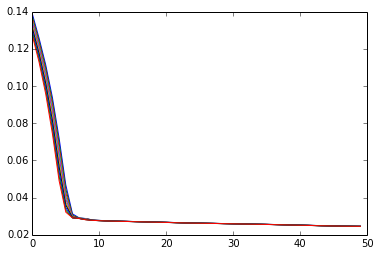

In [71]:
plt.cla()
plt.plot(loss)

In [75]:
pred = model.predict(ttX)
pred = np.reshape(pred,(pred.shape[0],pred.shape[2]))
print pred.shape
print scaler.inverse_transform(pred).flatten()

(7, 6)
[ 122.67771149  133.24873352  100.97615814  126.58989716  102.55397034
  132.1566925   128.71554565  123.1078186   113.4261322   129.04116821
  103.81758118  125.82540131  128.37702942  135.94543457  103.22322083
  133.96566772  100.42305756  134.1678009   129.10804749  124.37378693
  123.5542984   126.81556702  114.94237518  124.42448425  128.86433411
  116.38199615  123.45081329  125.00163269  108.93902588  121.27199554
  122.1749115   115.43099976  118.98014832  117.03385162  111.16542053
  120.0302124   121.28703308  134.67434692   95.70235443  126.39608002
   99.3536911   133.69346619]


In [56]:
print scaler.inverse_transform(pred[0]).flatten()

[ 123.32791138  123.86416626  119.44670868  123.90890503  110.3468399
  125.33629608]
